In [1]:
# **Cell 1: Overview**
#
# This notebook demonstrates how to:
# 1. Download and extract a chat file (if needed) from Google Drive using `gdown`.
# 2. Load, clean, and process the data from a WhatsApp-style chat text file.
# 3. Perform anonymization using a named entity recognition pipeline (DictaBERT-NER),
#    combined with a custom dictionary-based approach.
# 4. Apply a second pass of censoring (dictionary-based).
# 5. Compare the anonymized results against a GOLD standard file, calculating precision, recall, and F1 score.
#
# Key points:
# - We use `remove_sub_entities(all_ents)` to prefer large entities ("preferBig" approach).
# - We also skip partial matches that end in the middle of a Hebrew word (like "שבר" from "שברכה").
# - Finally, we produce an evaluation with a custom matching function (`custom_is_match`) that counts partial containment as a match.


In [2]:


# **Cell 2: Imports and Helper Functions**
# This cell contains all the imports and utility functions, such as:
# - `extract_data` for downloading & extracting a ZIP from Google Drive.
# - `data_processing` class for loading and cleaning chat data.
# - `split_if_too_long` to chunk text if it exceeds a certain length.
# - `generate_hebrew_variants` for Hebrew name prefixes.
# - `improved_name_pattern` for precise Hebrew word boundaries.
# - `overlap_range`, `multiword_and_subwords`, and `remove_sub_entities` for advanced entity manipulations.

import re
import unicodedata
import pandas as pd
import os
import zipfile
import gdown
import ast
import numpy as np
from collections import defaultdict
from transformers import pipeline
from tokenizers.decoders import WordPiece
import matplotlib.pyplot as plt
import seaborn as sns

def extract_data(drive_id, file_name):
    """
    Downloads and extracts a ZIP file from Google Drive using gdown,
    and places it in the 'Data/' folder.
    """
    destination = "Data/"
    os.makedirs(destination, exist_ok=True)
    gdown.download(f"https://drive.google.com/uc?id={drive_id}", destination, quiet=False)
    zip_path = os.path.join(destination, f"{file_name}.zip")
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destination)
        os.remove(zip_path)

class data_processing:
    """
    This class holds our chat DataFrame and methods for:
      - Cleaning Hebrew text (removing emojis, special WhatsApp tokens, etc.).
      - Loading the chat data from a WhatsApp-like txt file.
      - Grouping messages into a 'message_id' if they occur within X hours of each other.
    """
    def __init__(self):
        self.df = None

    def clean_hebrew_text(self, txt):
        txt = unicodedata.normalize('NFC', txt)
        # Remove emojis and similar
        txt = re.sub(r'[\U00010000-\U0010FFFF]+','', txt)
        # Remove certain leftover tokens
        txt = re.sub(r'\u200f|<המדיה לא נכללה>|<ההודעה נערכה>|הודעה זו נמחקה','', txt)
        return txt

    def load_chat(self, file_path):
        print("Loading chat file...")
        with open(file_path,'r',encoding='utf-8') as f:
            content = f.read()

        pattern= r'(\d{1,2}\.\d{1,2}\.\d{4}),\s(\d{1,2}:\d{2})\s-\s([^:]+):\s(.+)'
        messages=[]
        for line in content.split('\n'):
            match= re.match(pattern, line)
            if match:
                d,t,s,msg = match.groups()
                messages.append({
                    'date': d,
                    'time': t,
                    'sender': s.strip(),
                    'content': self.clean_hebrew_text(msg.strip())
                })
        df= pd.DataFrame(messages)
        df= df[df['content'].astype(bool)]
        df['id']= range(1, len(df)+1)
        df['content_len']= df['content'].str.len()
        print(f"Loaded {len(df)} messages")
        self.df= df

    def add_message_id(self, time_gap=24):
        """
        Groups messages under the same message_id if they occur within 'time_gap' hours of each other.
        """
        self.df['datetime']= pd.to_datetime(self.df['date']+' '+self.df['time'], format='%d.%m.%Y %H:%M')
        self.df.sort_values('datetime', inplace=True)
        msg_id=1
        prev_dt=None
        for idx,row in self.df.iterrows():
            dt= row['datetime']
            if prev_dt is not None:
                diff= (dt - prev_dt).total_seconds()
                # If more than time_gap hours (24h by default) have passed, we increment message_id
                if diff> time_gap*3600:
                    msg_id+=1
            self.df.at[idx,'message_id']= msg_id
            prev_dt= dt

        self.df.drop(columns=['datetime'], inplace=True)
        self.df['message_id']= self.df['message_id'].astype(int)

    def get_df(self):
        return self.df

def split_if_too_long(rows_list, max_chars=1000):
    """
    Splits the rows into sub-batches if their combined text length exceeds 'max_chars'.
    """
    sub_batches=[]
    current_batch=[]
    current_len=0
    for row in rows_list:
        txt_len= len(row['content'])
        needed= txt_len + (1 if current_batch else 0)
        if current_batch and (current_len+needed)> max_chars:
            sub_batches.append(current_batch)
            current_batch= [row]
            current_len= txt_len
        else:
            if current_batch:
                current_len+=1
            current_batch.append(row)
            current_len+= txt_len
    if current_batch:
        sub_batches.append(current_batch)
    return sub_batches

def generate_hebrew_variants(name):
    """
    Produces variations of a Hebrew name with common prefixes (e.g. 'מ'+name, 'כש'+name, etc.).
    """
    prefixes=["","ל","ב","מ","כש","ש","ה","כ","ו"]
    out=set()
    for p in prefixes:
        out.add(p+name)
    return out

def improved_name_pattern(name):
    """
    Regex pattern for searching Hebrew names:
    - (?<![א-ת]) ensures no Hebrew letter precedes it
    - (?![א-ת]) ensures no Hebrew letter follows
    """
    return rf"(?<![א-ת]){re.escape(name)}(?![א-ת])"

def overlap_range(s1,e1,s2,e2):
    """Check if [s1,e1) overlaps with [s2,e2)."""
    return not (e1<=s2 or s1>=e2)

def multiword_and_subwords(base_ent):
    """
    If the recognized entity has spaces, produce sub-entities for each word as well.
    E.g., "גלעד כץ" -> both ["גלעד כץ", "גלעד", "כץ"].
    """
    splitted_ents=[base_ent]
    if ' ' in base_ent['word']:
        parts= base_ent['word'].split(' ')
        start= base_ent['start']
        curr= start
        for i,p in enumerate(parts):
            splitted_ents.append({
                'start':curr,
                'end':curr+len(p),
                'word':p,
                'entity_group': base_ent['entity_group']
            })
            curr+= len(p)
            if i<(len(parts)-1):
                curr+=1
    return splitted_ents

def remove_sub_entities(all_ents):
    """
    Removes sub-entities if a larger entity fully encompasses them.
    For example, if we have both "גלעד כץ" (start=0,end=8) and "גלעד" (start=0,end=5),
    we remove "גלעד" and keep "גלעד כץ".
    """
    all_ents_sorted = sorted(all_ents, key=lambda x: (x['end'] - x['start']), reverse=True)
    final = []
    removed_indices = set()

    for i, big in enumerate(all_ents_sorted):
        if i in removed_indices:
            continue
        for j in range(i+1, len(all_ents_sorted)):
            if j in removed_indices:
                continue
            small = all_ents_sorted[j]
            # If 'small' is fully within 'big'
            if (small['start'] >= big['start'] and
                small['end']   <= big['end']   and
                not (small['start']==big['start'] and small['end']==big['end'])):
                removed_indices.add(j)
        final.append(big)

    final.sort(key=lambda x: x['start'])
    return final


In [3]:

# **Cell 3: The RollingAnonymizer Class**
# This class orchestrates:
# 1. A single NER call for a sub-batch of messages.
# 2. A dictionary-based approach to detect known names.
# 3. A final censorship pass that replaces the identified entities with asterisks.

class RollingAnonymizer:
    def __init__(self, max_chars=1000):
        self.ner = pipeline('ner', model='dicta-il/dictabert-large-ner', aggregation_strategy='simple')
        self.ner.tokenizer.backend_tokenizer.decoder = WordPiece()
        self.name_dict= set()
        self.max_chars= max_chars

    def regex_anonymizer(self, text):
        """
        Detects private info (phone, ID, etc.) by regex.
        """
        patterns={
            'phone':r'972[-\s]?0?(?:[23489]|5[0-9])[-\s]?\d{7}\b',
            'id':r'\b\d{9}\b',
            'email':r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
            'credit_card':r'\b(?:\d{4}[-\s]?){3}\d{4}\b',
            'website':r'(?:https?://\S+|www\.\S+)'
        }
        out=[]
        for kind,pat in patterns.items():
            for m in re.finditer(pat, text):
                out.append({
                    'start':m.start(),
                    'end':m.end(),
                    'word':m.group(),
                    'entity_group': kind.upper()
                })
        return out

    def process_subbatch(self, sub_rows):
        """
        Processes a single sub-batch of messages:
        1) Merges them into one text.
        2) Runs NER to find PER entities.
        3) Runs regex for phone/ID/email, etc.
        4) Adds dictionary-based detections (from self.name_dict).
        5) Censors the matched entities in the original lines.
        """
        df_sub= pd.DataFrame(sub_rows).copy()
        joined_text=''
        offset_map=[]
        curr_offset=0

        # Merge the text
        for i,r in df_sub.iterrows():
            txt= r['content']
            offset_map.append((r['id'], curr_offset, curr_offset+len(txt)))
            joined_text+= txt
            curr_offset+= len(txt)
            if i<(len(df_sub)-1):
                joined_text+=' '
                curr_offset+=1

        # 1) NER
        ner_out= self.ner(joined_text)
        per_entities=[]
        for e in ner_out:
            if e['entity_group']=='PER':
                # Additional check: skip partial if an immediate Hebrew letter follows
                if e['end'] < len(joined_text):
                    next_char = joined_text[e['end']]
                    # e.g. "שבר" in "שברכה" => skip
                    if re.match(r'[א-ת]', next_char):
                        continue

                base_ent= {
                    'start': e['start'],
                    'end': e['end'],
                    'word': e['word'],
                    'entity_group': 'PER'
                }
                expansions= multiword_and_subwords(base_ent)
                per_entities.extend(expansions)
                # Add expansions to name_dict
                for ex in expansions:
                    self.name_dict.update(generate_hebrew_variants(ex['word']))

        # 2) REGEX
        regex_ents= self.regex_anonymizer(joined_text)

        # 3) Union
        all_ents= per_entities + regex_ents

        # 4) Dictionary-based search
        for name in sorted(self.name_dict, key=len, reverse=True):
            pat= improved_name_pattern(name)
            for m in re.finditer(pat, joined_text):
                s,e= m.start(), m.end()
                if not any(overlap_range(s,e, ent['start'], ent['end']) for ent in all_ents):
                    base_ent= {
                        'start':s,
                        'end':e,
                        'word': joined_text[s:e],
                        'entity_group':'PER'
                    }
                    expansions= multiword_and_subwords(base_ent)
                    all_ents.extend(expansions)

        # 5) Remove sub-entities in favor of bigger ones
        all_ents = remove_sub_entities(all_ents)

        # 6) Sort final entities
        all_ents.sort(key=lambda x:x['start'])

        # 7) Map each entity to the relevant row ID
        ents_by_row= defaultdict(list)
        for ent in all_ents:
            for (rid,r_start,r_end) in offset_map:
                if ent['start']>= r_start and ent['end']<= r_end:
                    local_s= ent['start']-r_start
                    local_e= ent['end']-r_start
                    ents_by_row[rid].append({
                        'start': local_s,
                        'end': local_e,
                        'word': ent['word'],
                        'entity_group': ent['entity_group']
                    })
                    break

        # 8) Actual censorship
        df_sub['censored_content']=None
        df_sub['ner_output']= None
        df_sub['censored_words']= None

        for i,r in df_sub.iterrows():
            rid= r['id']
            original_text= r['content']
            if rid not in ents_by_row:
                df_sub.at[i,'censored_content']= original_text
                df_sub.at[i,'ner_output']='[]'
                df_sub.at[i,'censored_words']='[]'
                continue

            these_ents= sorted(ents_by_row[rid], key=lambda x:x['start'])
            shift=0
            cwords=[]
            new_text= original_text

            for ent in these_ents:
                s= ent['start']+shift
                e= ent['end']+shift
                w= ent['word']
                stars= '*'*len(w)
                new_text= new_text[:s]+stars+new_text[e:]
                shift+= len(stars)-(e-s)
                cwords.append(w)

            df_sub.at[i,'censored_content']= new_text
            df_sub.at[i,'ner_output']= str(these_ents)
            df_sub.at[i,'censored_words']= str(cwords)

        return df_sub

    def process_message_id(self, df_group):
        """
        Splits each group into smaller sub-batches if needed,
        then processes them with process_subbatch.
        """
        rows_list= df_group.to_dict('records')
        sub_batches= split_if_too_long(rows_list, self.max_chars)

        combined_df= pd.DataFrame()
        for sb in sub_batches:
            sub_res= self.process_subbatch(sb)
            combined_df= pd.concat([combined_df, sub_res], ignore_index=True)
        return combined_df

    def anonymize_chat(self, df):
        """
        Runs the full anonymization across all message_ids.
        """
        sorted_mids= sorted(df['message_id'].unique())
        final_df= pd.DataFrame()
        for mid in sorted_mids:
            subdf= df[df['message_id']==mid].copy()
            group_res= self.process_message_id(subdf)
            final_df= pd.concat([final_df, group_res], ignore_index=True)
        return final_df


In [4]:
# **Cell 4: Second Pass Censor**
#
# This function runs over the output from the first anonymization stage, searching for any additional
# dictionary-based names that might still appear. It censors those, and adds them to `censored_words` so that
# they are recognized in the final evaluation.

def second_pass_censor(df, name_dict):
    """
    A second pass that searches for any leftover names in 'censored_content',
    then censors them and updates 'censored_words' accordingly.
    """
    df2 = df.copy()

    sorted_names = sorted(name_dict, key=len, reverse=True)
    for i, row in df2.iterrows():
        text = row['censored_content']
        if not isinstance(text, str) or not text.strip():
            continue

        try:
            old_censored_list = ast.literal_eval(row['censored_words'])
            if not isinstance(old_censored_list, list):
                old_censored_list = []
        except:
            old_censored_list = []
        old_censored_set = set(old_censored_list)

        new_text = text
        found_ents = []
        for name in sorted_names:
            pat = improved_name_pattern(name)
            for m in re.finditer(pat, new_text):
                found_ents.append((m.start(), m.end(), m.group()))

        found_ents.sort(key=lambda x: x[0])
        shift = 0
        for s, e, w in found_ents:
            s += shift
            e += shift
            stars = '*' * (e - s)
            new_text = new_text[:s] + stars + new_text[e:]
            shift += len(stars) - (e - s)
            old_censored_set.add(w)

        df2.at[i, 'censored_content'] = new_text
        df2.at[i, 'censored_words'] = str(list(old_censored_set))

    return df2


Downloading...
From: https://drive.google.com/uc?id=1OpYoVnxeP6gdjnLv-n1xWVBGMTeu2ViC
To: /content/Data/project_chat.zip
100%|██████████| 19.5k/19.5k [00:00<00:00, 26.1MB/s]


Loading chat file...
Loaded 712 messages


Device set to use cpu


Saved rolled_anonymized_multiword_substring_FINAL_noIndex.xlsx (after second pass)

=== Evaluation without relying on EntityIndex ===
Total Gold Entities: 128
Total Predicted Entities: 129
Correct Matches: 128
Precision: 0.992
Recall: 1.000
F1 Score: 0.996
Saved rolled_*_FINAL_noIndex.xlsx with AllCensoredContent included


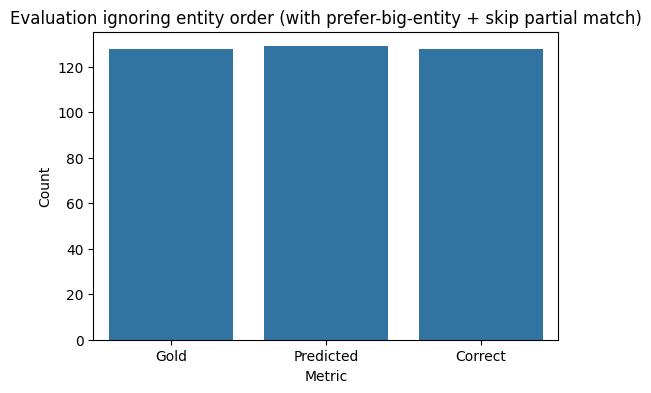

In [7]:
# **Cell 5: Main Demo and Evaluation**
# 1. (Optionally) extract data from Google Drive.
# 2. Load, clean, and parse the chat file.
# 3. Run the first anonymization pass with `RollingAnonymizer`.
# 4. Run the second pass (`second_pass_censor`).
# 5. Save to Excel.
# 6. Load the result for an evaluation vs. a 'NEW_GOLD_BRACKETS.xlsx' file:
#    - We unify predicted tokens per ID.
#    - We unify gold tokens per ID.
#    - We do a custom matching function (`custom_is_match`) that checks if `pred in gold` or `gold in pred`.
# 7. Compute Precision, Recall, and F1. Save the details to separate Excel files. Finally, show a summary bar plot.

if __name__=='__main__':
    # 1) (Optional) extract data from a Drive zip
    extract_data('1OpYoVnxeP6gdjnLv-n1xWVBGMTeu2ViC','project_chat')

    # 2) Load and process chat
    dp= data_processing()
    dp.load_chat('Data/project_chat.txt')
    dp.add_message_id(time_gap=24)
    df= dp.get_df()

    # 3) First anonymization pass
    anonymizer= RollingAnonymizer(max_chars=1000)
    df_out= anonymizer.anonymize_chat(df)
    final_name_dict = anonymizer.name_dict.copy()

    # 4) Second pass
    df_out2 = second_pass_censor(df_out, final_name_dict)

    # 5) Save final result
    df_out2.to_excel('rolled_anonymized_multiword_substring_FINAL_noIndex.xlsx', index=False)
    print('Saved rolled_anonymized_multiword_substring_FINAL_noIndex.xlsx (after second pass)')

    #################################################################
    # 6) Evaluation vs GOLD (no EntityIndex)
    #################################################################
    df_out_loaded= pd.read_excel('rolled_anonymized_multiword_substring_FINAL_noIndex.xlsx')
    if 'id' in df_out_loaded.columns:
        df_out_loaded.rename(columns={'id':'ID'}, inplace=True)

    def safe_parse_list(s):
        try:
            if pd.isnull(s) or not isinstance(s, str):
                return []
            return ast.literal_eval(s)
        except:
            return []
    df_out_loaded['PredTokens'] = df_out_loaded['censored_words'].apply(safe_parse_list)

    # Load GOLD
    df_gold= pd.read_excel('NEW_GOLD_BRACKETS.xlsx')
    if 'id' in df_gold.columns:
        df_gold.rename(columns={'id':'ID'}, inplace=True)
    df_gold.rename(columns={'censored_words':'GoldToken'}, inplace=True)

    def clean_gold_token(x):
        if isinstance(x,str):
            return x.strip().strip('[]').strip('"').strip('\'')
        return x
    df_gold['GoldToken_clean']= df_gold['GoldToken'].apply(clean_gold_token)

    gold_grouped = df_gold.groupby('ID')['GoldToken_clean'].apply(list).reset_index()
    gold_grouped.rename(columns={'GoldToken_clean':'GoldTokens'}, inplace=True)

    pred_grouped = df_out_loaded.groupby('ID')['PredTokens'].apply(list).reset_index()

    def flatten(list_of_lists):
        flat = []
        for sub in list_of_lists:
            flat.extend(sub)
        return flat
    pred_grouped['PredTokens'] = pred_grouped['PredTokens'].apply(flatten)

    df_eval = pd.merge(gold_grouped, pred_grouped, on='ID', how='outer')
    df_eval['GoldTokens'] = df_eval['GoldTokens'].apply(lambda x: x if isinstance(x,list) else [])
    df_eval['PredTokens'] = df_eval['PredTokens'].apply(lambda x: x if isinstance(x,list) else [])

    def custom_is_match(pred, gold):
        if not pred or not gold:
            return False
        pred = pred.strip()
        gold = gold.strip()
        # partial containment => match
        return (pred in gold) or (gold in pred)

    total_gold_all = 0
    total_pred_all = 0
    total_matched_all = 0

    match_details = []

    for idx, row in df_eval.iterrows():
        ID = row['ID']
        gold_list = row['GoldTokens']
        pred_list = row['PredTokens']

        used_gold = [False]*len(gold_list)
        matched_count = 0

        for p in pred_list:
            found_spot = -1
            for i,g in enumerate(gold_list):
                if not used_gold[i] and custom_is_match(p,g):
                    found_spot = i
                    break
            if found_spot >= 0:
                used_gold[found_spot] = True
                matched_count +=1
                match_details.append({
                    'ID':ID,
                    'Pred':p,
                    'Gold':gold_list[found_spot],
                    'IsMatch':True
                })
            else:
                match_details.append({
                    'ID':ID,
                    'Pred':p,
                    'Gold':None,
                    'IsMatch':False
                })
        # Mark any unused gold as missed
        for i,g in enumerate(gold_list):
            if not used_gold[i]:
                match_details.append({
                    'ID':ID,
                    'Pred':None,
                    'Gold':g,
                    'IsMatch':False
                })

        total_gold_all += len(gold_list)
        total_pred_all += len(pred_list)
        total_matched_all += matched_count

    precision = total_matched_all / total_pred_all if total_pred_all else 0
    recall = total_matched_all / total_gold_all if total_gold_all else 0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0

    print('\n=== Evaluation without relying on EntityIndex ===')
    print(f'Total Gold Entities: {total_gold_all}')
    print(f'Total Predicted Entities: {total_pred_all}')
    print(f'Correct Matches: {total_matched_all}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')

    # 7) Save details, create a summary plot
    df_match_details = pd.DataFrame(match_details)

    temp = df_out_loaded.groupby('ID')['censored_content'].apply(
        lambda x: "\n".join(x.astype(str))
    ).reset_index()
    temp.rename(columns={'censored_content':'AllCensoredContent'}, inplace=True)

    df_match_details = df_match_details.merge(temp, on='ID', how='left')

    df_false_pos = df_match_details[
        (df_match_details['Pred'].notnull()) & (df_match_details['IsMatch']==False)
    ].copy()
    df_missed = df_match_details[
        (df_match_details['Gold'].notnull()) & (df_match_details['IsMatch']==False)
    ].copy()
    df_correct = df_match_details[df_match_details['IsMatch']==True].copy()

    df_correct.to_excel("rolled_correct_FINAL_noIndex.xlsx", index=False)
    df_false_pos.to_excel("rolled_false_pos_FINAL_noIndex.xlsx", index=False)
    df_missed.to_excel("rolled_missed_FINAL_noIndex.xlsx", index=False)
    print("Saved rolled_*_FINAL_noIndex.xlsx with AllCensoredContent included")

    metrics_df= pd.DataFrame({
        'Metric':['Gold','Predicted','Correct'],
        'Count':[total_gold_all, total_pred_all, total_matched_all]
    })
    plt.figure(figsize=(6,4))
    sns.barplot(data=metrics_df, x='Metric', y='Count')
    plt.title('Evaluation ignoring entity order (with prefer-big-entity + skip partial match)')
    plt.show()
